# Восстановление золота из руды

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import seaborn as sns

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 5000)

## Подготовка данных

### Обзор данных

In [2]:
recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
recovery_train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [4]:
recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [6]:
recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [7]:
recovery_train.describe().T

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142034,1.369586,0.000000e+00,4.211620,4.994652,5.859540,1.600195e+01
final.output.concentrate_pb,14148.0,10.132960,1.654930,0.000000e+00,9.297355,10.297144,11.170603,1.703190e+01
final.output.concentrate_sol,13938.0,9.202849,2.790516,0.000000e+00,7.484645,8.845462,10.487508,1.812485e+01
final.output.concentrate_au,14149.0,44.003792,4.905261,0.000000e+00,43.276111,44.872436,46.166425,5.275664e+01
final.output.recovery,14149.0,66.518832,10.295402,0.000000e+00,62.545817,67.432775,72.346428,1.000000e+02
final.output.tail_ag,14149.0,9.607035,2.319069,0.000000e+00,7.997429,9.480270,11.003707,1.955215e+01
final.output.tail_pb,14049.0,2.597298,0.971843,0.000000e+00,1.905973,2.592022,3.241723,5.639565e+00
final.output.tail_sol,14144.0,10.512122,3.003617,0.000000e+00,8.811324,10.514621,11.933009,2.231773e+01
final.output.tail_au,14149.0,2.918421,0.903712,0.000000e+00,2.368607,2.851025,3.434764,8.197408e+00
primary_cleaner.input.sulfate,14129.0,133.320659,39.431659,3.111820e-03,107.006651,133.018328,159.825396,2.501278e+02


In [8]:
recovery_test.describe().T

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner.input.feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner.input.xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner.state.floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner.state.floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner.state.floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner.state.floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner.state.floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner.state.floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035


In [9]:
recovery_full.describe().T

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19438.0,5.168470,1.372348,0.000000e+00,4.251240,5.066094,5.895527,1.600195e+01
final.output.concentrate_pb,19438.0,9.978895,1.669240,0.000000e+00,9.137262,10.102433,11.035769,1.703190e+01
final.output.concentrate_sol,19228.0,9.501224,2.787537,0.000000e+00,7.722820,9.218961,10.947813,1.961572e+01
final.output.concentrate_au,19439.0,44.076513,5.129784,0.000000e+00,43.402215,45.011244,46.275313,5.275664e+01
final.output.recovery,19439.0,67.050208,10.125840,0.000000e+00,63.299712,68.172738,72.686642,1.000000e+02
final.output.tail_ag,19438.0,9.688589,2.328642,0.000000e+00,8.062878,9.743623,11.134294,1.955215e+01
final.output.tail_pb,19338.0,2.705795,0.949077,0.000000e+00,2.040119,2.748730,3.333216,5.804178e+00
final.output.tail_sol,19433.0,10.583728,2.868782,0.000000e+00,8.938947,10.622456,12.104271,2.231773e+01
final.output.tail_au,19439.0,3.042467,0.922808,0.000000e+00,2.461138,2.984909,3.571351,8.245022e+00
primary_cleaner.input.sulfate,19415.0,144.624774,44.464071,3.111820e-03,114.107029,143.232103,175.075656,2.659831e+02


### Проверка эффективности обогащения

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Проверим расчет эффективности обогащения

</div>

In [10]:
C = recovery_train['rougher.output.concentrate_au']
F = recovery_train['rougher.input.feed_au']
T = recovery_train['rougher.output.tail_au']

mean_absolute_error(recovery_train['rougher.output.recovery'], (C*(F-T)) / (F*(C-T))*100)

9.73512347450521e-15

In [11]:
(recovery_train['rougher.output.recovery'] - (C*(F-T)) / (F*(C-T))*100) \
    .sort_values(ascending=False) \
    .head(5)

12589    8.526513e-14
10634    7.105427e-14
4215     7.105427e-14
8920     5.684342e-14
3683     5.684342e-14
dtype: float64

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Проверка прошла успешно )
    Эффективность обогащения, доступная в данных, и расчитанная нами, совпадает.
    
    Это хорошо, после предобраборки данных, нужно будет этот параметр пересчитать, т.к. данные, на основе которых он расчитывается, могут измениться

</div>

### Анализ признаков, недоступных в тестовой выборке

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Посмотрим, какие столбцы есть в тестовой выбрке и нет в тренировочной. И наоборот 

</div>

In [12]:
recovery_train_columns = recovery_train.columns
recovery_test_columns = recovery_test.columns

In [13]:
diff_train_test_columns = list(set(recovery_train_columns) - set(recovery_test_columns))
diff_test_train_columns = list(set(recovery_test_columns) - set(recovery_train_columns))

In [14]:
sorted(diff_train_test_columns)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [15]:
diff_test_train_columns

[]

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Видим, что переменные, содержащие параметры продукта (output) и расчетные характеристики (calculation) присутствуют только в тренировочной выборке. Так же в тестовой выборке нет целевых признаков (recovery)
    
    Радует то, что нет столбцов, которые есть в тестовой выборке, но нет в тренировочной )
    
    Удалим из тренировочной выборки столбцы, не доступные нам в тестовой выборке (кроме целевых признаков)

</div>

In [16]:
remove_col = list(set(diff_train_test_columns) - set(['final.output.recovery', 'rougher.output.recovery']))

In [17]:
print(f"Количество столбцов до удаления признаков: {len(recovery_train.columns)}")
recovery_train = recovery_train.drop(remove_col, axis=1)
print(f"Количество столбцов после удаления признаков: {len(recovery_train.columns)}")

Количество столбцов до удаления признаков: 87
Количество столбцов после удаления признаков: 55


### Предобработка данных

#### Сравнение тестовой и тренировочной выборок

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Посмотрим пропуски

</div>

In [18]:
feature_columns = list(set(recovery_test.columns) - set(['date']))

In [19]:
def show_missing(df):
    return pd.DataFrame(
        [round((df.isna().mean()*100),2), df.isna().sum()]).T \
        .rename(columns={0: 'percent_na', 1: 'count_na'}) \
        .query('count_na>=1') \
        .sort_values(by='count_na', ascending=False) \
        .style.background_gradient('coolwarm')

In [20]:
show_missing(recovery_test)

,percent_na,count_na
rougher.input.floatbank11_xanthate,0.470000,25.000000
rougher.input.feed_sol,0.400000,21.000000
secondary_cleaner.state.floatbank3_a_air,0.170000,9.000000
rougher.input.floatbank11_sulfate,0.150000,8.000000
primary_cleaner.input.depressant,0.090000,5.000000
rougher.input.floatbank10_sulfate,0.090000,5.000000
primary_cleaner.input.sulfate,0.080000,4.000000
primary_cleaner.input.xanthate,0.080000,4.000000
rougher.input.feed_rate,0.060000,3.000000
secondary_cleaner.state.floatbank2_a_air,0.060000,3.000000


In [21]:
show_missing(recovery_train[feature_columns])

,percent_na,count_na
rougher.state.floatbank10_e_air,3.080000,436.000000
rougher.input.floatbank11_xanthate,3.020000,428.000000
secondary_cleaner.state.floatbank2_a_air,1.530000,217.000000
rougher.input.feed_size,1.020000,144.000000
rougher.input.feed_pb,0.710000,100.000000
primary_cleaner.input.xanthate,0.710000,100.000000
rougher.input.feed_sol,0.550000,78.000000
rougher.input.floatbank11_sulfate,0.250000,36.000000
primary_cleaner.input.depressant,0.230000,32.000000
rougher.input.floatbank10_sulfate,0.200000,29.000000


<div style="border:solid gray 2.0px; padding: 10px"> 
    
    В тренировочных данных признаки rougher.state.floatbank10_e_air и rougher.input.floatbank11_xanthate имеют по 3.08% и 3.02%  пропусков. 
    В тестовых данных в этих признаках 0 и 0.47% пропусков.
    С учетом кодичества данных в тестовой и тренировочной выборках, очень маловероятно, что такое разделение могло пройти случайно
    
    Посмотрим, распределение гранул сырья в обоих выборках

</div>

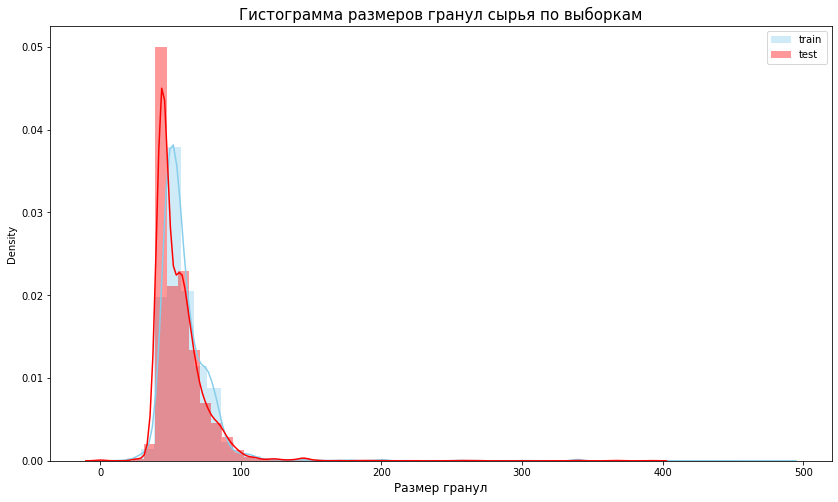

In [22]:
data_train = recovery_train.loc[recovery_train['rougher.input.feed_size'].notnull()]
data_test = recovery_test.loc[recovery_test['rougher.input.feed_size'].notnull()]

plt.subplots(figsize = (14,8))
sns.distplot(data_train['rougher.input.feed_size'], color="skyblue", label="train", kde=True)
sns.distplot(data_test['rougher.input.feed_size'] , color="red"    , label="test", kde=True)

plt.legend()
plt.title('Гистограмма размеров гранул сырья по выборкам', fontsize = 15)
plt.xlabel("Размер гранул", fontsize = 12);


In [23]:
recovery_train['rougher.input.feed_size'].describe()

count    14005.000000
mean        60.110518
std         22.418485
min          9.659576
25%         48.973027
50%         55.373885
75%         66.080172
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [24]:
recovery_test['rougher.input.feed_size'].describe()

count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher.input.feed_size, dtype: float64

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Распределения похожи, но не так сильно, как хотелось бы.

</div>

In [25]:
test_size = recovery_test.shape[0] / recovery_full.shape[0]
test_size

0.2721333401923967

#### Работа с пропусками

In [26]:
show_missing(recovery_full[feature_columns])

,percent_na,count_na
rougher.input.floatbank11_xanthate,2.330000,453.000000
rougher.state.floatbank10_e_air,2.240000,436.000000
secondary_cleaner.state.floatbank2_a_air,1.130000,220.000000
rougher.input.feed_size,0.750000,145.000000
primary_cleaner.input.xanthate,0.540000,104.000000
rougher.input.feed_pb,0.510000,100.000000
rougher.input.feed_sol,0.510000,99.000000
rougher.input.floatbank11_sulfate,0.230000,44.000000
primary_cleaner.input.depressant,0.190000,37.000000
rougher.input.floatbank10_sulfate,0.170000,34.000000


<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Посмотрим, сколько пропусков в строчках

</div>

In [27]:
recovery_full['count_na'] = recovery_full.apply(lambda x: len(recovery_full.columns) - x.count(), axis=1)
recovery_full['count_na'].value_counts().sort_values(ascending=False)

0     16094
1      2632
2       477
3       153
4        51
5        14
6         9
8         4
7         2
9         2
44        1
Name: count_na, dtype: int64

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    В тренировочной выборке есть одна строчка с 44 пропусками! Это много, удалим ее.

</div>

In [28]:
recovery_full = recovery_full.query('count_na!=44').drop('count_na', axis=1)

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Теперь восстановим данные. Воспользуемся из описания проекта информацией о  том, что соседние по времени параметры часто похожи.
    
    Идея восстановления: 
     - отсортировать данные по времени 
     - восстановить пропуск средним из предыдущего и последующего заполненных значений этого парамента.
    
    Напишем функцию (recovering), которая будет принимать столбец значений и возвращать столбец с восстановленными данными
    
   
</div>

In [29]:
def recovering(col):
    bfill = col.fillna(method='bfill', axis=0)
    ffill = col.fillna(method='ffill', axis=0)
    col_rec = col.fillna((bfill+ffill)/2)
    return pd.Series(col_rec)

In [30]:
recovery_full['date'] = pd.to_datetime(recovery_full['date'], format='%Y-%m-%dT%H:%M:%S')
recovery_full = recovery_full.sort_values('date')

In [31]:
for col in feature_columns:
    recovery_full[col] = recovering(recovery_full[col])

In [32]:
show_missing(recovery_full[feature_columns])

,percent_na,count_na


## Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [33]:
def concentrate_distplot(df, element, element_label, hist=True):
    fig = plt.figure(figsize=(14,8))

    sns.distplot(df[f'rougher.input.feed{element}']                 , color="blue"   , label="Исходное сырье", kde=True, hist=hist)
    sns.distplot(df[f'rougher.output.concentrate{element}']         , color="red"    , label="После флотации", kde=True, hist=hist)
    sns.distplot(df[f'primary_cleaner.output.concentrate{element}'] , color="green"  , label="После первичной очистки", kde=True, hist=hist)
    sns.distplot(df[f'final.output.concentrate{element}']           , color="orange" , label="Финальный концентрат", kde=True, hist=hist)

    plt.title(f'Распределение суммарной концентрации на разных стадиях {element_label}', fontsize = 15)
    plt.xlabel("Концентрация", fontsize = 12)
    plt.legend()
    plt.show();

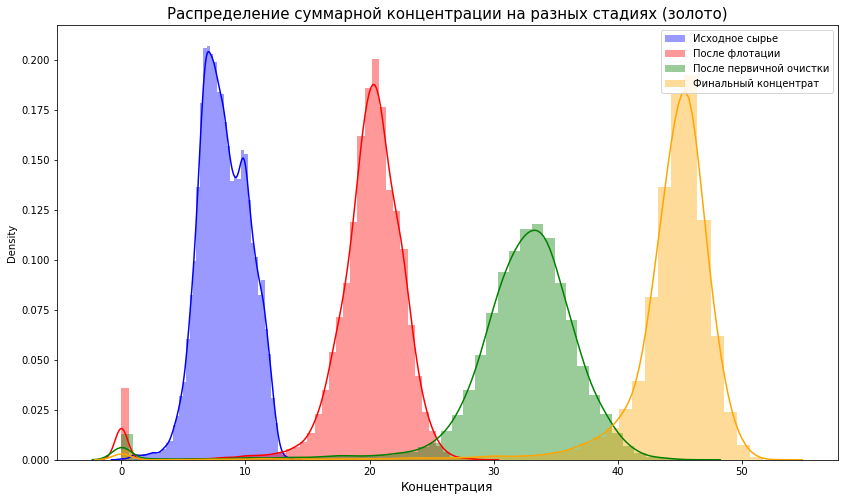

In [34]:
concentrate_distplot(recovery_full, element='_au', element_label='(золото)')

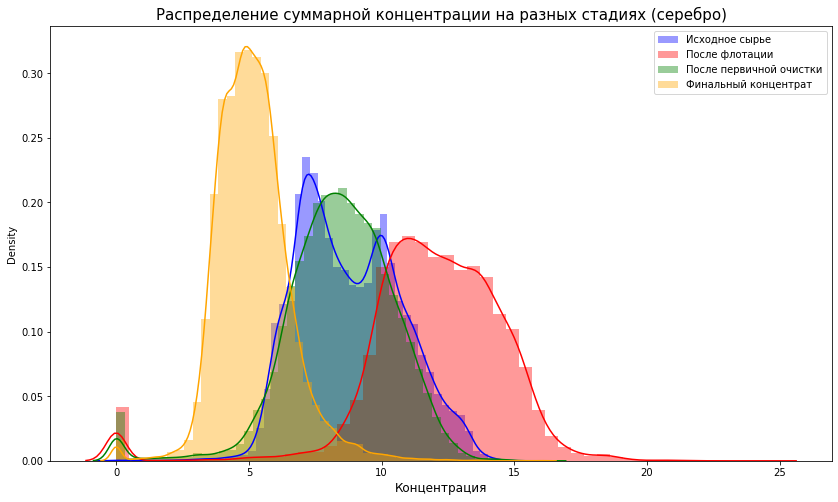

In [35]:
concentrate_distplot(recovery_full, element='_ag', element_label='(серебро)')

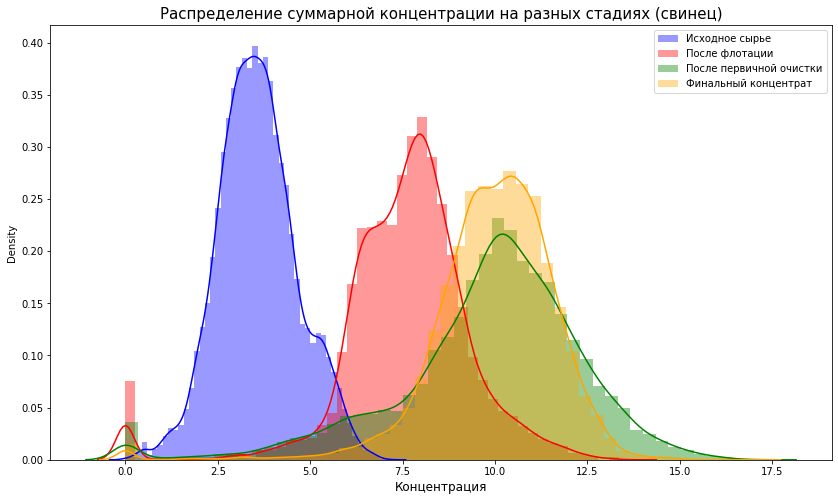

In [36]:
concentrate_distplot(recovery_full, element='_pb', element_label='(свинец)')

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    - концентрация золота эффективно увеличивается от стадии к стадии
    - концентрация свинца увеличивается, на этапах флотации и первичной очистки
    - концентрация серебра остается примерно на одном уровне
    - интересно, что на входе золота и серебра было примерно поровну )
    

</div>

### Cуммарная концентрация всех веществ на разных стадиях

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Добвим суммарные концентрации в данные и построим распределения
    
</div>

In [38]:
for stage in ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']:
    stage_col = []
    for element in ['au', 'ag', 'pb', 'sol']:
        for column in recovery_full.columns:
            if column.find(element)>=0 and column.find(stage)>=0:
                stage_col.append(column)
    recovery_full[stage] = recovery_full[stage_col].sum(axis=1)

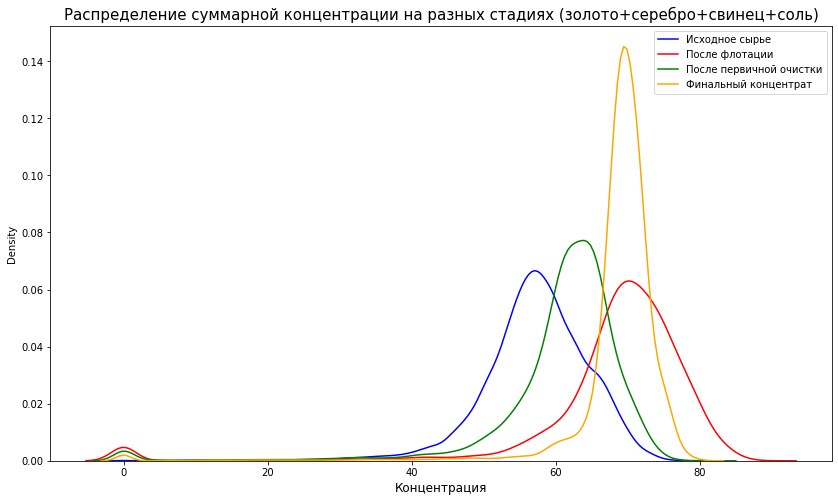

In [39]:
concentrate_distplot(recovery_full, element='', element_label='(золото+серебро+свинец+соль)', hist=False)

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Видно, что есть пики около нуля, указывающие на нулевую суммарную концентрацию веществ.
    Скорее врего, в этих случаях были ошибки в замером. Удалим такие строчки
    
</div>

In [40]:
print(f"Количество строк до чистки: {recovery_full.shape[0]}")

recovery_full = \
    recovery_full.loc[(
        (recovery_full['rougher.input.feed']>0.1) & 
        (recovery_full['rougher.output.concentrate']>0.1) &
        (recovery_full['primary_cleaner.output.concentrate']>0.1) &
        (recovery_full['final.output.concentrate']>0.1) \
        )]
         
print(f"Количество строк после чистки: {recovery_full.shape[0]}")         

Количество строк до чистки: 19438
Количество строк после чистки: 18724


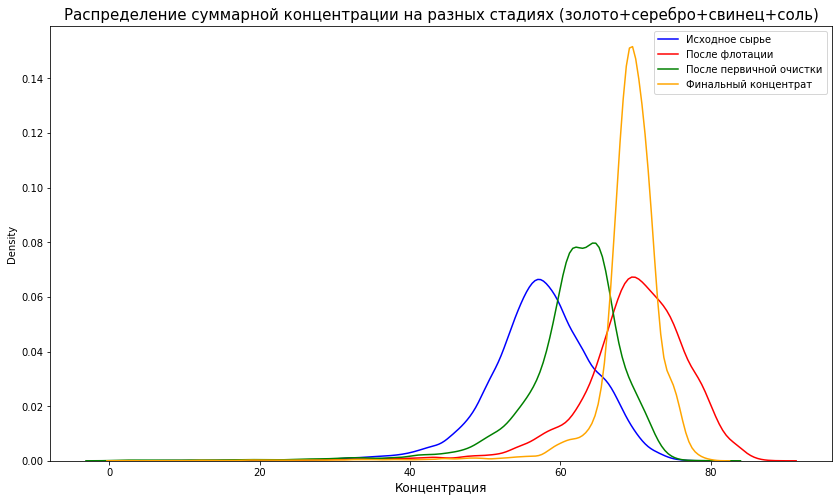

In [41]:
concentrate_distplot(recovery_full, element='', element_label='(золото+серебро+свинец+соль)', hist=False)

## Модель

### Функция для вычисления sMAPE

In [45]:
def smape_total(smape_rougher, smape_final):
    return smape_rougher*0.25 + smape_final*0.75

def smape(target, pred):
    target = np.array(target)
    pred = np.array(pred)
    return sum(abs(target - pred)/ (abs(target) + abs(pred)/2)) *100 / len(target)*(1)

### Разбиение выборки

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Мы восстановили данные на полной выборке, теперь разобьем ее на тестовую и тренировочную, отобрав те же строчки, что и при первичном исхлдном разбиении
    
</div>

In [46]:
date_train = recovery_train['date']
date_test = recovery_test['date']

recovery_train_new = recovery_full.query('date in @date_train')[recovery_train.columns]
recovery_test_new = recovery_full.query('date in @date_test')[recovery_train.columns]

In [47]:
print(f"Размер тренировочной выборки: {recovery_train_new.shape}")
print(f"Размер тестовой выборки: {recovery_test_new.shape}")

Размер тренировочной выборки: (13601, 55)
Размер тестовой выборки: (5123, 55)


In [48]:
features_train = recovery_train_new.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_train_rou = recovery_train_new['rougher.output.recovery']
target_train_fin = recovery_train_new['final.output.recovery']

features_test = recovery_test_new.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_test_rou = recovery_test_new['rougher.output.recovery']
target_test_fin = recovery_test_new['final.output.recovery']

### Обучение моделей

In [49]:
scorer =  make_scorer(smape, greater_is_better=False)

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Во избежание повторения кода, напишем две функции:
     - reg_no_grid. Применяется для моделей, в которых не используем тюнинг гиперпараметров. Возвращает значение smape.
     - reg_no_grid. Применяется для моделей, в которых используем тюнинг гиперпараметров. Возвращает гиперпараметры лучшей подобранной модели и ее smape.
    
</div>

In [50]:
def reg_no_grid(model, features, target, scoring=scorer, cv=5):
    return np.mean(cross_val_score(model, features, target, cv=cv, scoring=scoring))*(-1)

In [51]:
def reg_grid(model, features, target, param_grid, scoring=scorer, cv=5):
    search = GridSearchCV(model, param, scoring=scoring, cv=cv)
    search.fit(features, target)
    best_params = search.best_params_
    best_score = search.best_score_
    
    return best_params, best_score*(-1)

#### LinearRegression

In [77]:
reg_no_grid(LinearRegression(), features_train, target_train_rou)

4.838172566100094

In [53]:
reg_no_grid(LinearRegression(), features_train, target_train_fin)

7.413642312060645

#### RidgeCV

In [54]:
reg_no_grid(RidgeCV(), features_train, target_train_rou)

4.835955108510445

In [55]:
reg_no_grid(RidgeCV(), features_train, target_train_fin)

7.409264811362661

#### KNeighborsRegressor

In [56]:
param = {
    'n_neighbors': range (1, 10)
       }

In [57]:
reg_grid(KNeighborsRegressor(), features_train, target_train_rou, param)

({'n_neighbors': 7}, 6.167818962314304)

In [58]:
reg_grid(KNeighborsRegressor(), features_train, target_train_fin, param)

({'n_neighbors': 7}, 8.072046968404045)

#### DecisionTreeRegressor

In [59]:
param = {
    'max_depth': range (1, 100, 3)
       }

In [60]:
reg_grid(DecisionTreeRegressor(), features_train, target_train_rou, param)

({'max_depth': 4}, 4.82139207416338)

In [61]:
reg_grid(DecisionTreeRegressor(), features_train, target_train_fin, param)

({'max_depth': 4}, 6.572714315101512)

In [62]:
#({'max_depth': 13}, 2.356286967373085)
#({'max_depth': 10}, 5.0106407339827275)

#### RandomForestRegressor

In [63]:
param = {
    'max_depth': range(1, 50, 10),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(1, 30, 5)
}

In [64]:
reg_grid(RandomForestRegressor(), features_train, target_train_rou, param)

({'max_depth': 21, 'max_features': 'log2', 'n_estimators': 21},
 4.110092734509685)

In [65]:
reg_grid(RandomForestRegressor(), features_train, target_train_fin, param)

({'max_depth': 31, 'max_features': 'sqrt', 'n_estimators': 21},
 6.252225608578103)

#### DummyRegressor

In [67]:
model = DummyRegressor(strategy='median')
np.mean(cross_val_score(model, features_train, target_train_rou, cv=5, scoring=scorer))*(-1)

5.255122122334912

In [68]:
model = DummyRegressor(strategy='median')
np.mean(cross_val_score(model, features_train, target_train_fin, cv=5, scoring=scorer))*(-1)

7.034367489427623

### Тестирование лучшей модели

<div style="border:solid gray 2.0px; padding: 10px"> 

На валидационных данных:
    
 - для предсказания **rougher.output.recovery** лучше всего себя показала модель RandomForestRegressor с гиперпараметрами:
    - 'max_depth': 21
    - 'max_features': 'log2'
    - 'n_estimators': 21

    
 - для предсказания **final.output.recovery** лучше всего себя показала модель RandomForestRegressor с гиперпараметрами:

    - 'max_depth': 31
    - 'max_features': 'sqrt'
    - 'n_estimators': 21

    
</div>

#### RandomForestRegressor

In [69]:
def test_model(model, features_train, target_train, features_test, target_test, scoring=scorer, cv=5):
    rou_search = GridSearchCV(model, param, scoring=scoring, cv=cv)
    rou_search.fit(features_train, target_train)
    return rou_search.score(features_test, target_test)*(-1)

In [70]:
param = {'max_depth': [11], 'max_features': ['log2'], 'n_estimators': [26]}

In [71]:
smape_rou = test_model(RandomForestRegressor(), features_train, target_train_rou, features_test, target_test_rou)
smape_fin = test_model(RandomForestRegressor(), features_train, target_train_fin, features_test, target_test_fin)

In [72]:
smape_total(smape_rou, smape_fin)

4.9195819723840355

#### Сравнение с DummyRegressor

In [73]:
smape_dummy_rou = smape(target_test_rou, pd.Series(target_train_rou.median(), index = target_test_rou.index))
smape_dummy_fin = smape(target_test_fin, pd.Series(target_train_fin.median(), index = target_test_fin.index))

In [74]:
smape_total(smape_dummy_rou, smape_dummy_fin)

4.968913252558708

## Вывод

<div style="border:solid gray 2.0px; padding: 10px"> 

1. В процессе флотации и очистки руды, содержание золота эффективно увеличивается: концентрация золота на финальном этапе примерно в 5 раз выше, чем в исходной руде. 
    
   При этом сожержание других металлов и соли остается примерно на том же уровне. 
    
   Интересно, что в начальной смеси золотоносной руды золота и серебра было примерно поровну. Золоту повезло быть более ценным металлом. 

<span style="color: white">. </span> 

2. Разные модели показывают себя по-разному в предсказании эффективности обогащения.
    Лучше всего на обоих этапах показала себя модель RandomForestRegressor с гиперпараметрами:
    - 'max_depth': 11
    - 'max_features': 'log2'
    - 'n_estimators': 26
    
</div>